In [1]:
from utils_data_handling import *
from utils_preprocessing import *

The array has a shape of:  (6, 6000000)


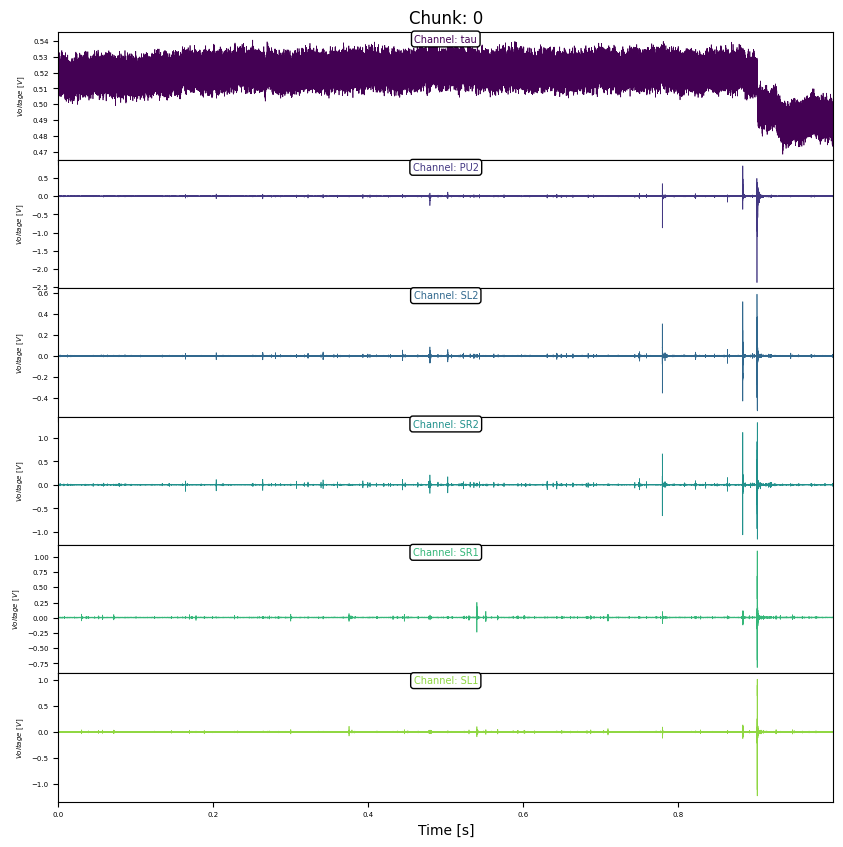

In [2]:
input_folder = ".../Progetto_Chris/Coding_Chris/Data_Chris/s0133_all/"
channels_names=['tau','PU2','SL2','SR2','SR1','SL1']
list_channels=[1,2,3,4,5,6] # list channels you want to use

float_type='float32'
chunk=0   # IMPOSTARLO A 0 QUANDO AVREMO TUTTI I CHUNK (DA 0 A 200 AD ESEMPIO), QUESTO è IL CHUNK DI PARTENZA
fs=6e6      # sample rate
f_chunk=6e6 # numb of samples for each chunk (i.e. 1 chunk = 1 sec)

AE_array=create_data_chunk(input_folder,list_channels,chunk,float_type=float_type) # chank zero, 6 channels
print('The array has a shape of: ',AE_array.shape)
plot_chunk(fs,AE_array,channels_names,chunkname=chunk)


# questo sotto è un secondo (un chunk) di registrazione. Poiché il sample rate è 6e6 (quindi 6000000 samples in un secondo)
# abbamo 6 canali (1 per lo shear stress, 5 per gli altri sensori (uno solo riguarda onde p, gli altri 4 sono per onde s))

# choosing the signal with higher variance

In [3]:
import os

# how many chunks do we have?
number_of_chunks = 0
for f in os.listdir(input_folder):
    if f.startswith("ae_chunk"):
        number_of_chunks += 1

print(f"We have {number_of_chunks} chunks")

We have 200 chunks


Even tough the variance of the sum is not the sum of variances, it is a good estimation for our purpose. We infact want to calculate the variance on the single chunk, since the entire signal is too computational complex. 

Ci sono algoritmi o modi per non caricare tutti i dati in una sola volta però stica, a noi circa va bene così. 

In [4]:
# we want to choose the channel that has overall the highest variance (more information)

# contains at [i,j] the variance of the audio of signal j recorded by channel i 
variance_matrix = np.array([
    [np.var(create_data_chunk_single_channel(input_folder, ch, chunk + chunk_idx, float_type=float_type))
     for chunk_idx in range(number_of_chunks)]
    for ch in list_channels
])

chosen_channel = int(np.argmax(np.sum(variance_matrix, axis=1)) + 1)


"""
more readable code:

variance_matrix = np.zeros((len(list_channels), number_of_chunks))

for chunk_idx in range(number_of_chunks): 
    # chunk index starts from 1 not 0
    for ch in list_channels:
        specific_signal = create_data_chunk_single_channel(input_folder, ch, chunk+chunk_idx, float_type=float_type)
        variance_matrix[ch-1, chunk_idx] = np.var(specific_signal)
"""
pass

In [5]:
chosen_channel # check that it is not 1 since we want an acoustic information (1 is the shear stress)

2

# Now we want the entire signal (union of all chunks) only for the chosen channel

In [6]:
T=np.arange(f_chunk)

In [7]:
acoustic_data_raw, chosen_chunks = combine_chunks_single_channel(input_folder, chunk, chosen_channel, number_of_chunks, T, float_type=float_type)


In [8]:
acoustic_data_raw, acoustic_data_raw.shape #1_200_000_000

(array([-0.00036765,  0.00208333, -0.00355392, ...,  0.00012255,
         0.00196078, -0.00110294], dtype=float32),
 (1200000000,))

# building time to failure

In [9]:
# downsampling shear stress

fs_red=1000 # 1KHz
shear_stress = reduce_stress_from_acoustic(input_folder, chunk, fs, fs_red, step=number_of_chunks,f_chunk=f_chunk,float_type=float_type)

Max folder number: 199
The last chunk is the number:  199
Processing chunk: 0


In [10]:
shear_stress.shape, shear_stress # 200_000

((200000,),
 array([0.51288944, 0.51298716, 0.51340679, ..., 0.50202202, 0.50080981,
        0.50066824]))

(0.0, 199.999)

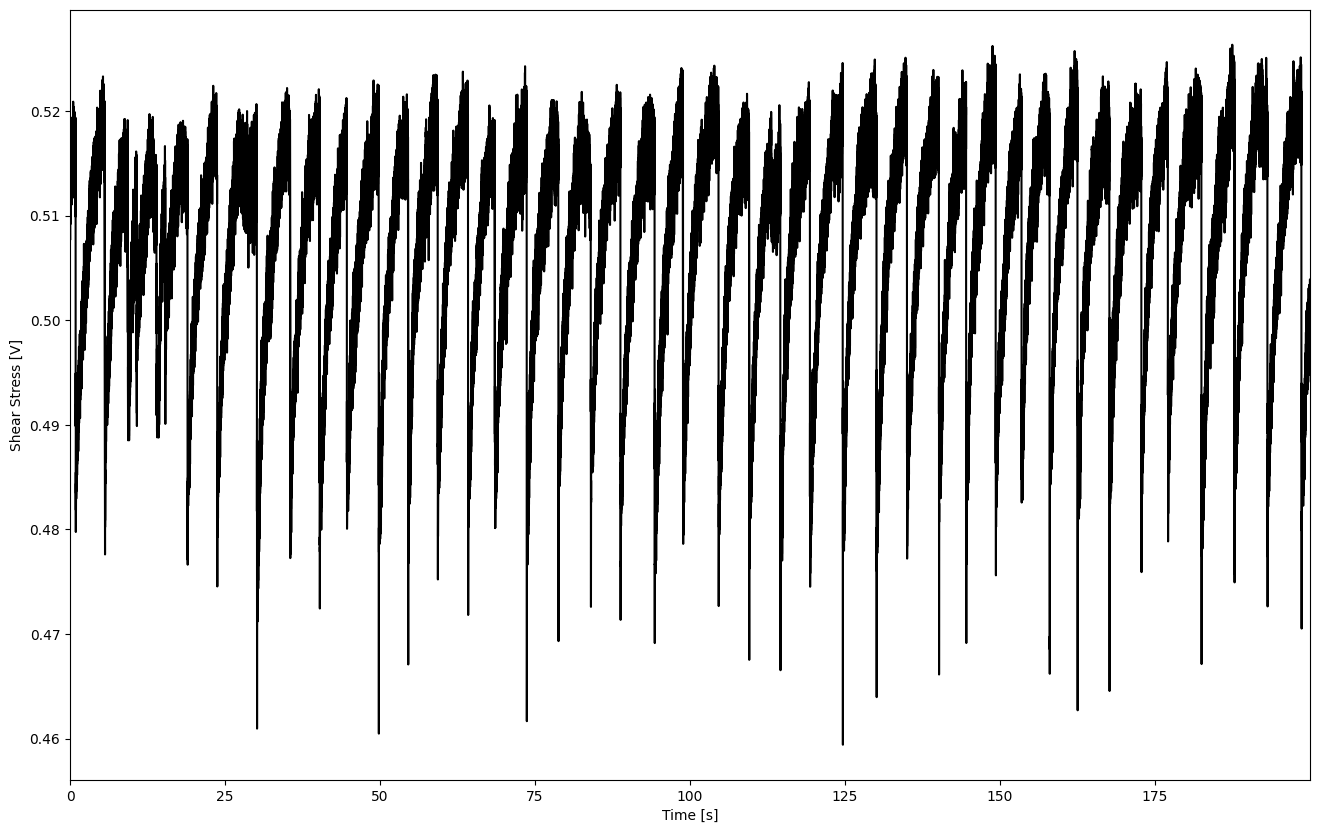

In [11]:
T = np.array(range(0, shear_stress.shape[0]))*(1/fs_red)

fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, shear_stress,color='k')
axs.set_ylabel('Shear Stress [V]')
axs.set_xlabel('Time [s]')
axs.set_xlim([T[0],T[-1]])

In [ ]:
def moving_average(ST, window_size):
  # keep the original dimension while smoothing
  return np.convolve(ST, np.ones(window_size)/window_size, mode='same')

denoised_shear_stress = moving_average(shear_stress,50)

In [14]:
denoised_shear_stress.shape, denoised_shear_stress

((200000,),
 array([0.25558579, 0.26577085, 0.27599656, ..., 0.28054361, 0.27052724,
        0.26053151]))

(0.0, 199.999)

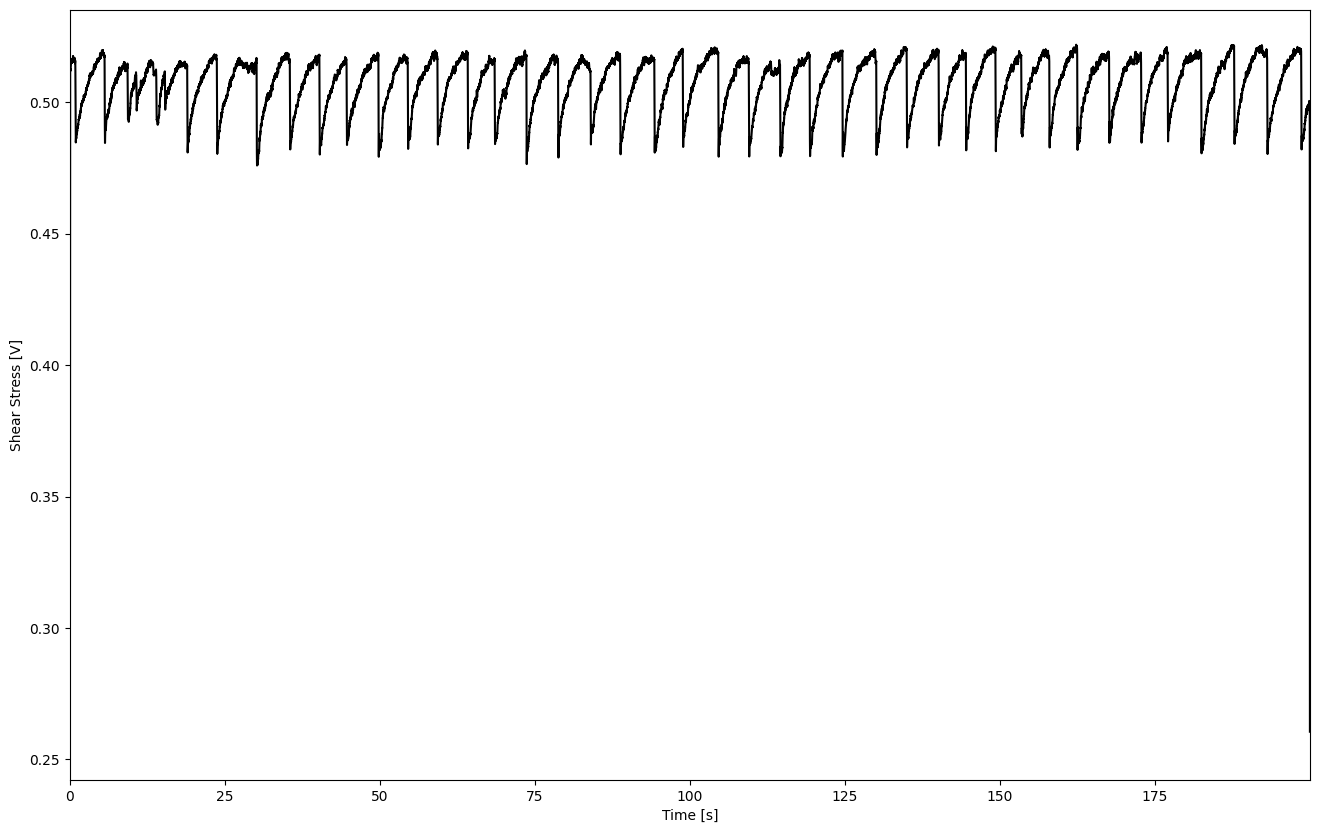

In [15]:
fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, denoised_shear_stress, color='k')
axs.set_ylabel('Shear Stress [V]')
axs.set_xlabel('Time [s]')
axs.set_xlim([T[0],T[-1]])

In [48]:
step_size = 30  # Numero di punti tra i valori utilizzati nel calcolo del rapporto incrementale
                # Lo step size non influisce solo sulla precisione della derivata, ma anche sui significant_points calcolati
                # scegliere uno step_size troppo piccolo porta ad avere più significant_points per lo stesso stress drop

# Calcola la prima derivata usando un passo maggiore
first_derivative = np.diff(denoised_shear_stress[::step_size]) / (1 * step_size) # Nel rapporto incrementale classico il denominatore è 1 se i dati sono equispaziati
                                                                      # qui moltiplichiamo per step_size perché non stiamo calcolando punto per punto, ma su una finestra
#SI PUò ANCHE FARE DIRETTAMENTE CON LA DERIVATA PRIMA

# Calcola la seconda derivata dal risultato della prima derivata
second_derivative = np.diff(first_derivative) / step_size

# Soglia per identificare cambiamenti significativi
threshold = 1.5 * np.std(second_derivative)
significant_points = np.where(np.abs(second_derivative) > threshold)[0] # vive nello spazio first_derivative.shape 

In [49]:
first_derivative.shape, denoised_shear_stress.shape, denoised_shear_stress, second_derivative.shape, significant_points.shape, significant_points

((6666,),
 (200000,),
 array([0.25558579, 0.26577085, 0.27599656, ..., 0.28054361, 0.27052724,
        0.26053151]),
 (6665,),
 (141,),
 array([   0,   28,   29,   30,  185,  186,  187,  188,  309,  311,  358,
         463,  510,  511,  629,  630,  631,  632,  789,  791, 1002, 1003,
        1004, 1005, 1006, 1181, 1183, 1340, 1342, 1486, 1487, 1488, 1489,
        1657, 1658, 1659, 1660, 1661, 1815, 1816, 1817, 1818, 1819, 1975,
        1977, 2138, 2139, 2140, 2282, 2283, 2284, 2453, 2455, 2457, 2623,
        2624, 2625, 2626, 2798, 2799, 2800, 2957, 2959, 3141, 3143, 3293,
        3294, 3295, 3296, 3484, 3485, 3486, 3487, 3649, 3650, 3651, 3817,
        3818, 3819, 3976, 3978, 4152, 4153, 4154, 4156, 4334, 4336, 4337,
        4497, 4498, 4499, 4500, 4669, 4670, 4671, 4673, 4816, 4817, 4818,
        4819, 4974, 4975, 4976, 4977, 5113, 5114, 5115, 5116, 5264, 5265,
        5266, 5267, 5268, 5414, 5415, 5416, 5417, 5418, 5586, 5588, 5589,
        5758, 5760, 5900, 5901, 5902, 5903, 6081, 

In [68]:
def unify_close_indices(significant_points, threshold=5):
    """
    Unifies consecutive indices in an array if the difference between them is less than 'threshold'.
    Only the first element of each group is retained.

    Parameters:
        significant_points (list or array): Array of indices to be unified.
        threshold (int): Maximum allowed distance to unify consecutive indices.

    Returns:
        list: A list of unified indices, retaining only the first of each group.
    """
    # Convert input to a NumPy array if it's not already
    significant_points = np.asarray(significant_points)

    if significant_points.size == 0:  # Check for empty array
        return []

    unified_indices = [int(significant_points[0])]  # Start with the first index

    for i in range(1, len(significant_points)):
        if significant_points[i] - significant_points[i-1] > threshold:
            unified_indices.append(int(significant_points[i]))  # Append only if far enough

    return np.array(unified_indices)




In [69]:
threshold = 5

significant_points = unify_close_indices(significant_points, threshold)
print("Unified Indices:", significant_points)

Unified Indices: [   0   28  185  309  358  463  510  629  789 1002 1181 1340 1486 1657
 1815 1975 2138 2282 2453 2623 2798 2957 3141 3293 3484 3649 3817 3976
 4152 4334 4497 4669 4816 4974 5113 5264 5414 5586 5758 5900 6081 6258
 6436 6618 6664]


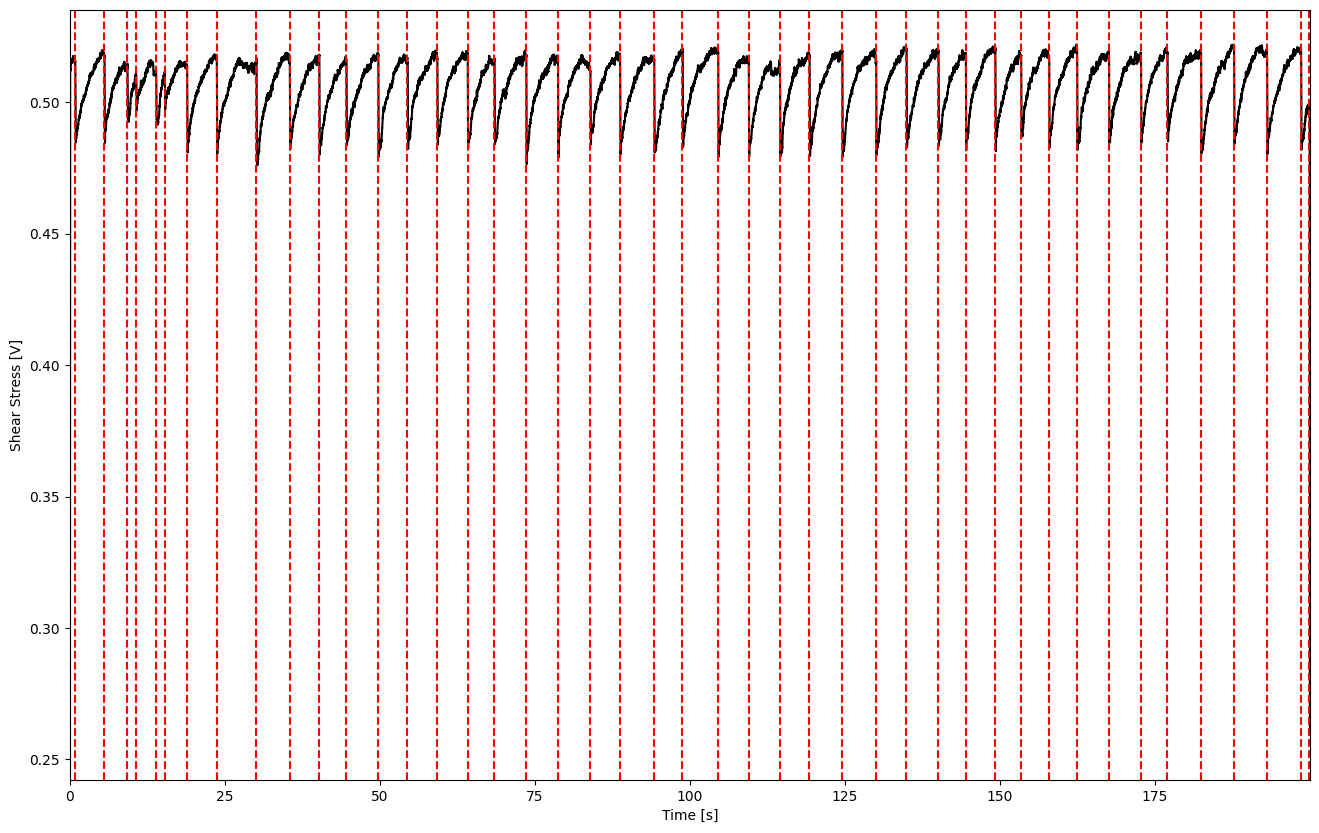

In [70]:
# plotting
fs_red=1000
T = np.array(range(0, denoised_shear_stress.shape[0]))*(1/fs_red)

# Convertire gli indici significativi alla scala di tempo
significant_times = significant_points * step_size * (1/fs_red)  # vive nello spazio first_derivative.shape * step_size 

fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, denoised_shear_stress,color='k')
axs.set_ylabel('Shear Stress [V]')
axs.set_xlabel('Time [s]')
axs.set_xlim([T[0],T[-1]])

# Aggiungere le rette verticali per i punti significativi
for t in significant_times:
    axs.axvline(x=t, color='red', linestyle='--', label='Significant Change' if t == significant_times[0] else "")


In [71]:
significant_times.shape, significant_points.shape

((45,), (45,))

In [72]:
significant_times, significant_points

(array([  0.  ,   0.84,   5.55,   9.27,  10.74,  13.89,  15.3 ,  18.87,
         23.67,  30.06,  35.43,  40.2 ,  44.58,  49.71,  54.45,  59.25,
         64.14,  68.46,  73.59,  78.69,  83.94,  88.71,  94.23,  98.79,
        104.52, 109.47, 114.51, 119.28, 124.56, 130.02, 134.91, 140.07,
        144.48, 149.22, 153.39, 157.92, 162.42, 167.58, 172.74, 177.  ,
        182.43, 187.74, 193.08, 198.54, 199.92]),
 array([   0,   28,  185,  309,  358,  463,  510,  629,  789, 1002, 1181,
        1340, 1486, 1657, 1815, 1975, 2138, 2282, 2453, 2623, 2798, 2957,
        3141, 3293, 3484, 3649, 3817, 3976, 4152, 4334, 4497, 4669, 4816,
        4974, 5113, 5264, 5414, 5586, 5758, 5900, 6081, 6258, 6436, 6618,
        6664]))

In [81]:
significant_points = significant_points[1:-1]

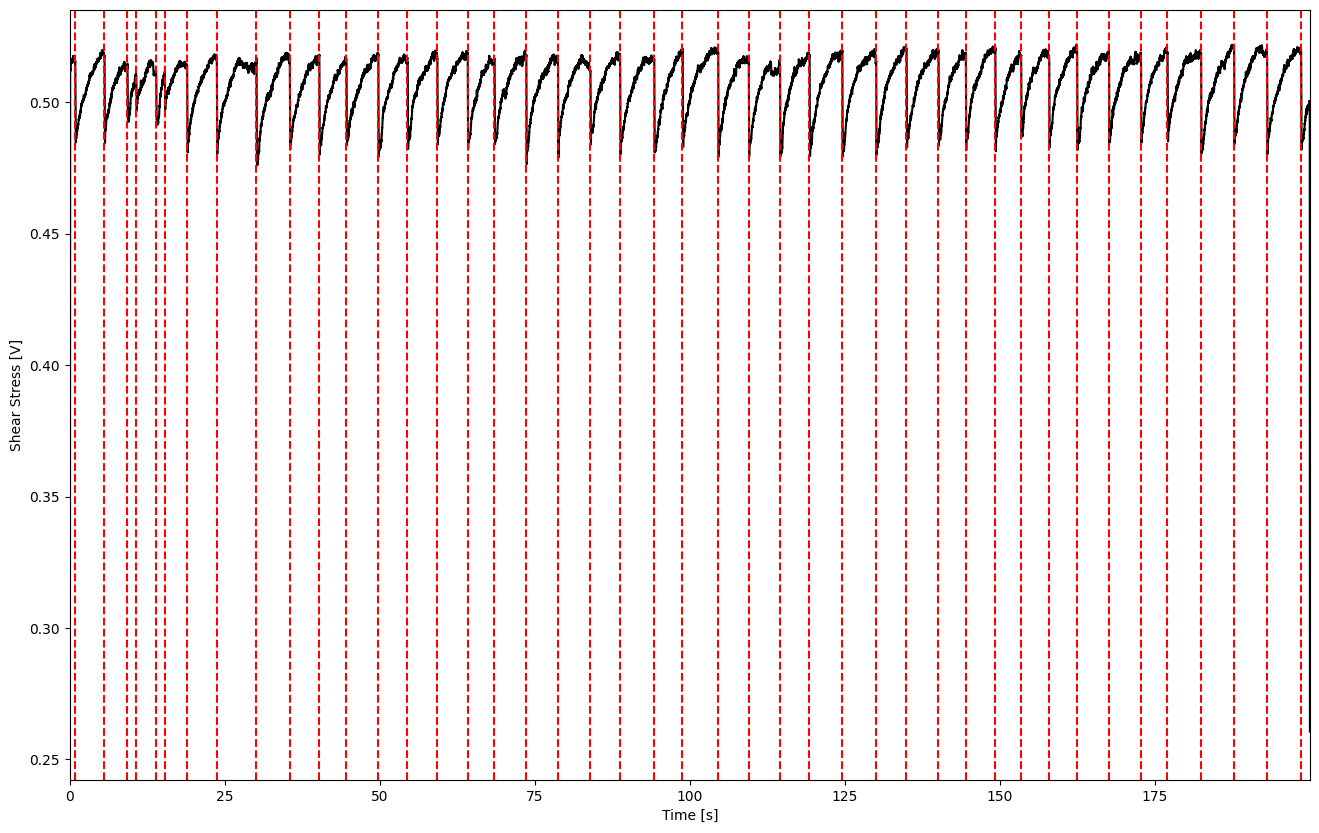

In [82]:
# plotting
fs_red=1000
T = np.array(range(0, denoised_shear_stress.shape[0]))*(1/fs_red)

# Convertire gli indici significativi alla scala di tempo
significant_times = significant_points * step_size * (1/fs_red)  # vive nello spazio first_derivative.shape * step_size 

fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, denoised_shear_stress,color='k')
axs.set_ylabel('Shear Stress [V]')
axs.set_xlabel('Time [s]')
axs.set_xlim([T[0],T[-1]])

# Aggiungere le rette verticali per i punti significativi
for t in significant_times:
    axs.axvline(x=t, color='red', linestyle='--', label='Significant Change' if t == significant_times[0] else "")

In [83]:
significant_times.shape, significant_points.shape

((43,), (43,))

In [85]:
denoised_shear_stress[significant_points * step_size]

array([0.51509154, 0.5176356 , 0.51403319, 0.50564511, 0.51235572,
       0.51138259, 0.51346166, 0.51637055, 0.51556032, 0.51538843,
       0.51785844, 0.51630787, 0.5176144 , 0.51552903, 0.5165339 ,
       0.5184577 , 0.51554589, 0.51739511, 0.51500842, 0.51186456,
       0.51780645, 0.51607982, 0.51942368, 0.51853816, 0.51481058,
       0.51342809, 0.51734405, 0.51939282, 0.51557422, 0.52008496,
       0.51954519, 0.51808511, 0.51941798, 0.51734526, 0.51763298,
       0.52082614, 0.51756408, 0.51739971, 0.51895277, 0.51831364,
       0.52110147, 0.51742464, 0.52003312])

In [86]:
significant_points = significant_points * step_size
significant_points

array([   840,   5550,   9270,  10740,  13890,  15300,  18870,  23670,
        30060,  35430,  40200,  44580,  49710,  54450,  59250,  64140,
        68460,  73590,  78690,  83940,  88710,  94230,  98790, 104520,
       109470, 114510, 119280, 124560, 130020, 134910, 140070, 144480,
       149220, 153390, 157920, 162420, 167580, 172740, 177000, 182430,
       187740, 193080, 198540])

In [ ]:
TTF = np.zeros_like(shear_stress)  # Initialize output array (same size as shear_stress: sr = 1kHz)

# Loop through all shear_stress indices
for i in range(len(shear_stress)):
    # Find significant points occurring at or after the current index
    next_points = [point for point in significant_points if point >= i]
    
    if next_points:  # If such points exist
        # Compute time to the closest significant point
        TTF[i] = (min(next_points) - i) * (1 / fs_red)
    else:  
        # No future events: set time to infinity
        TTF[i] = float('inf')

In [ ]:
TTF = np.zeros_like(shear_stress) # sr = 1 kHz

# Iterare su tutti gli indici di ST
for i in range(len(shear_stress)):
    # Calcolare la distanza al prossimo significant point
    # Considera solo i punti maggiori o uguali a i
    next_points = [point for point in significant_points if point >= i]
    if next_points:  # Se ci sono significant points successivi
        indexes_diff = min(next_points) - i 
        TTF[i] = indexes_diff * (1/fs_red)
    else:  
        TTF[i] = float('inf')  # if no other significant points are available there is no other event

# TTF = TTF[1:]


In [88]:
TTF.shape

(200000,)

(0.0, 199.999)

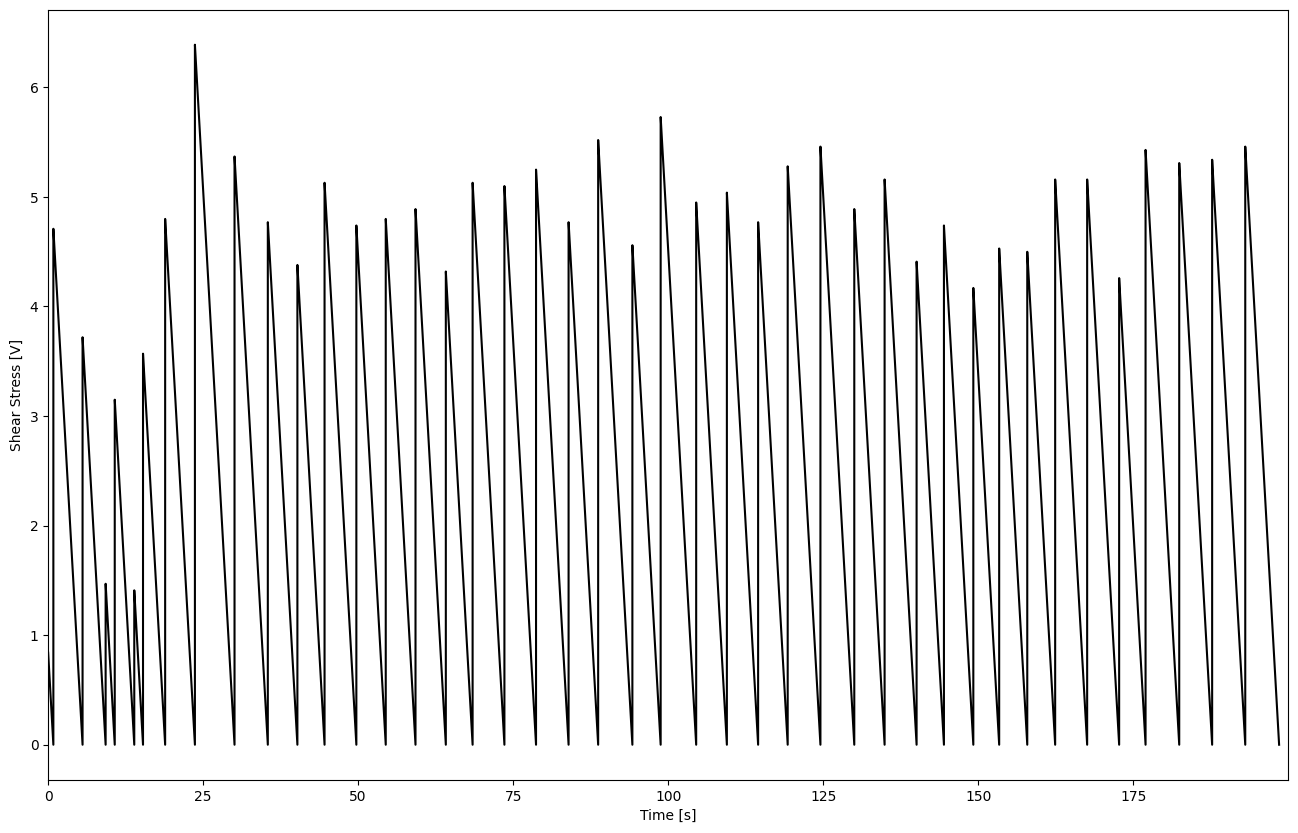

In [89]:
fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, TTF,color='k')
axs.set_ylabel('Shear Stress [V]')
axs.set_xlabel('Time [s]')
axs.set_xlim([T[0],T[-1]])

In [90]:
TTF.shape, shear_stress.shape

((200000,), (200000,))

In [91]:
TTF

array([0.84 , 0.839, 0.838, ...,   inf,   inf,   inf])

In [92]:
array_no_inf = TTF[~np.isinf(TTF)]
max(array_no_inf), len(array_no_inf)

(np.float64(6.389), 198541)

In [93]:
TTF.shape, acoustic_data_raw.shape

((200000,), (1200000000,))

In [94]:
# il primo zero non è in realtà zero
# TTF[0] = np.float64(4.590)

TTF

array([0.84 , 0.839, 0.838, ...,   inf,   inf,   inf])

In [96]:
points_each_point = int(fs / fs_red)
TTF_dense = np.zeros(int(len(TTF) * points_each_point))

# Ciclo per interpolazione
for k in range(len(TTF) - 1):  # Fino al penultimo elemento
    start_index = k * points_each_point
    end_index = (k + 1) * points_each_point
    
    # Se il prossimo valore è inf, riempi da qui in poi con inf
    if np.isinf(TTF[k]):
        TTF_dense[start_index:] = np.inf
        break  # Esci dal ciclo poiché non serve continuare
    
    # Calcolo delta: differenza tra due punti divisa per il numero di passi
    delta = (TTF[k + 1] - TTF[k]) / points_each_point
    
    # Assegna i valori interpolati
    for i in range(points_each_point):
        TTF_dense[start_index + i] = TTF[k] + i * delta

# Verifica risultato
print(TTF_dense)

[0.84       0.83999983 0.83999967 ...        inf        inf        inf]


/var/folders/xx/v5q7nzc15ds_31l2tyx3g5fw0000gn/T/ipykernel_48432/920808041.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  TTF_dense[start_index + i] = TTF[k] + i * delta


In [ ]:
# se fidamo che questa cella sia uguale perché non runna con 1 miliardo di punti

T_temp = np.arange(len(TTF_dense))
fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T_temp, TTF_dense,color='k')
axs.set_xlim([T_temp[0],T_temp[-1]])

In [97]:
TTF_dense.shape

(1200000000,)

In [98]:
TTF_dense, acoustic_data_raw

(array([0.84      , 0.83999983, 0.83999967, ...,        inf,        inf,
               inf]),
 array([-0.00036765,  0.00208333, -0.00355392, ...,  0.00012255,
         0.00196078, -0.00110294], dtype=float32))

In [99]:
TTF_dense.shape, acoustic_data_raw.shape

((1200000000,), (1200000000,))

In [100]:
# eliminare sia in TTF che in acoustic_raw_data tutti i valori dal primo indice corrispondente ad 'inf' in TTF in poi
TTF_dense_no_inf, acoustic_raw_data_no_inf = cut_at_first_inf(TTF_dense, acoustic_data_raw)

Indice del primo 'inf': 1191240001


In [101]:
TTF_dense_no_inf.shape, acoustic_raw_data_no_inf.shape

((1191240001,), (1191240001,))

In [102]:
TTF_dense_no_inf, acoustic_raw_data_no_inf

(array([8.40000000e-01, 8.39999833e-01, 8.39999667e-01, ...,
        3.33333333e-07, 1.66666667e-07,            nan]),
 array([-0.00036765,  0.00208333, -0.00355392, ...,  0.00208333,
         0.00281863, -0.00183824], dtype=float32))

In [104]:
# Conta il numero di valori NaN
num_nan = np.isnan(TTF_dense_no_inf).sum()
print(f"Numero di valori NaN: {num_nan}") # solo l'ultimo che in realtà è uno zero

Numero di valori NaN: 1


In [107]:
TTF_dense_no_inf[-1] = 0.0
TTF_dense_no_inf_fixed = TTF_dense_no_inf

TTF_dense_no_inf_fixed

array([8.40000000e-01, 8.39999833e-01, 8.39999667e-01, ...,
       3.33333333e-07, 1.66666667e-07, 0.00000000e+00])

In [108]:
TTF_dense_no_inf_fixed.shape, acoustic_raw_data_no_inf.shape

((1191240001,), (1191240001,))

# Preprocessing dati

Forse dovremmo prima normalizzare il segnale acoustic data?

Now we have TTF and acoustic data. Nota: acoustic data non è espresso in unità arbitrarie come invece lo era nei dati di kaggle

In [109]:
train_size = find_train_size(TTF_dense_no_inf_fixed, fraction=0.8) + 1
print(train_size) # circa 80% dei terremoti COMPLETI per il train

947520001


Problema: TTF dopo lo zero non va subito a 5 secondi ad esempio, ma ci sta un pezzetto in cui assume valori molto vicini a zero. Cioè non fa un salto da 0 a 5 sec, ma fa tipo [0, 0.75, 0.8, 5]

(0.0, 115740000.0)

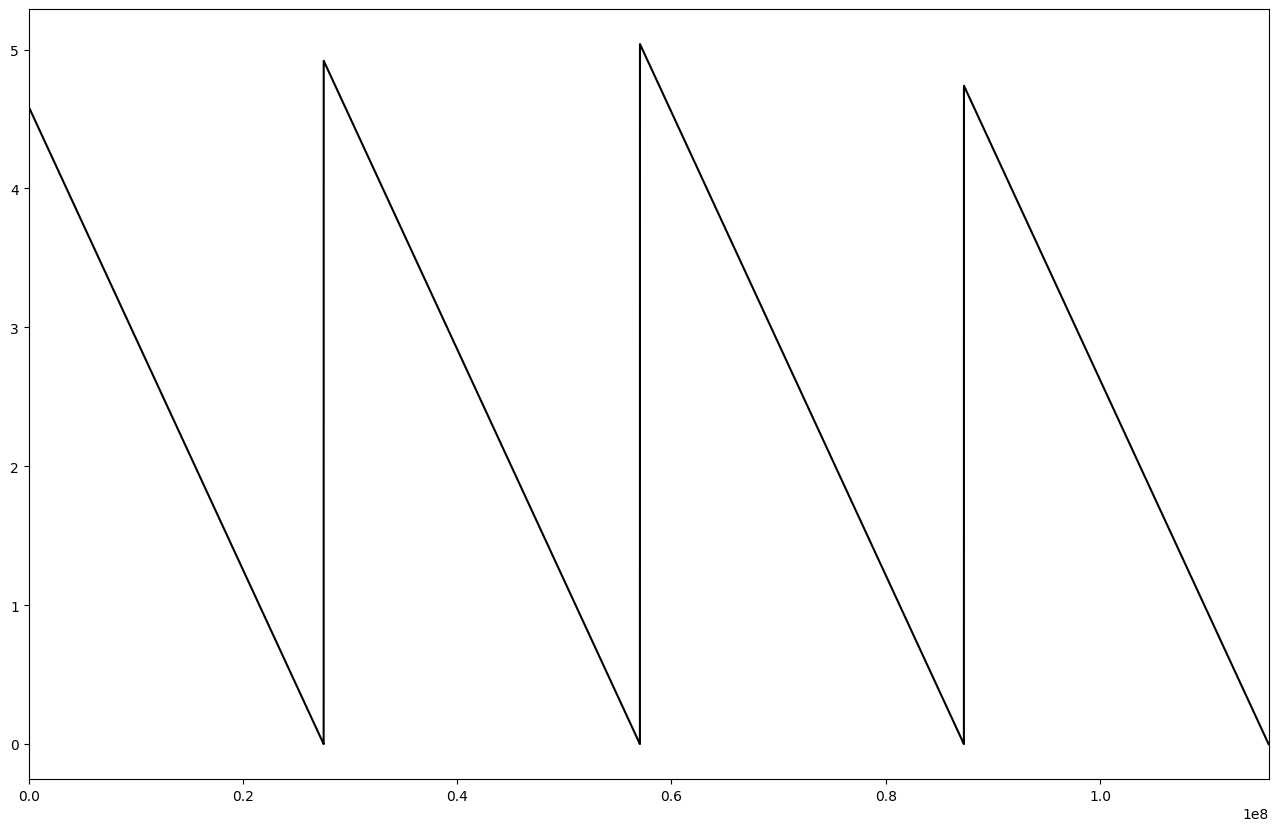

In [ ]:
# anche questo evitiamo di runnarlo per non far esplodere il pc

T = np.arange(len(TTF_dense_no_inf_fixed))
fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, TTF_dense_no_inf_fixed,color='k')
axs.set_xlim([T[0],T[-1]])

In [110]:
import pandas as pd

# Creazione dei due DataFrame: train e test
raw_train = pd.DataFrame({
    'acoustic_data': acoustic_raw_data_no_inf[:train_size],
    'time_to_failure': TTF_dense_no_inf_fixed[:train_size]
})

raw_test = pd.DataFrame({
    'acoustic_data': acoustic_raw_data_no_inf[train_size:],
    'time_to_failure': TTF_dense_no_inf_fixed[train_size:]
})

# Verifica delle dimensioni e dei tipi
print("Train DataFrame:")
print(raw_train.dtypes)
print(raw_train.shape)
print(raw_train.head())

print("\nTest DataFrame:")
print(raw_test.dtypes)
print(raw_test.shape)
print(raw_test.head())

Train DataFrame:
acoustic_data      float32
time_to_failure    float64
dtype: object
(947520001, 2)
   acoustic_data  time_to_failure
0      -0.000368         0.840000
1       0.002083         0.840000
2      -0.003554         0.840000
3       0.001838         0.840000
4       0.001471         0.839999

Test DataFrame:
acoustic_data      float32
time_to_failure    float64
dtype: object
(243720000, 2)
   acoustic_data  time_to_failure
0      -0.000613         0.000750
1       0.001716         0.001500
2      -0.000123         0.002249
3       0.000490         0.002999
4       0.001348         0.003749


In [134]:
np.random.seed(1337) # reproducibility
chosen_noise = np.zeros(150_000)

# np.random.normal(0, 0.5, 150_000)

Abbiamo terremoti circa ogni 5 secondi, ossia ogni 30_000_000 di samples. Nel caso di kaggle avevamo terremoti circa ogni 37_000_000. Diciamo che il segment size per ora lo prendiamo uguale. 

In [135]:
from utils_preprocessing import *

In [136]:
segment_size = 150_000

# indices_to_calculate di default è solo l'indice zero (cioè se non vogliamo spezzare il fenomeno)

indices_to_calculate_train = raw_train.index.values[::segment_size][:-1]
indices_to_calculate_test = raw_test.index.values[::segment_size][:-1]

# ritorna una array numpy contenente indici iniziali per dividere il dataset raw 
# (pandas dataframe) in segmenti di lunghezza 150000
# [::150_000] Applica uno slicing all’array degli indici, selezionando ogni 150,000-esimo valore.
# [:-1] Esclude l’ultimo valore dall’array ottenuto.
# L’ultimo indice viene escluso per evitare un errore quando si cerca di creare un segmento che eccede la lunghezza del dataset.


Lo stesso preprocessing va applicato sia a train che a test

In [137]:
train = sample_train_gen(raw_train, chosen_noise, segment_size=segment_size, indices_to_calculate=indices_to_calculate_train)
gc.collect()
test = sample_train_gen(raw_test, chosen_noise, segment_size=segment_size, indices_to_calculate=indices_to_calculate_test) # usiamo la funzione sample_train_gen perché qui abbiamo il dataset di test

  0%|          | 0/6316 [00:00<?, ?it/s]Python(50098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|          | 0/1624 [00:00<?, ?it/s]Python(50165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50166) MallocStackLogging: can'

In [138]:
print(type(train))
print(train.shape)
print(train.info())
print('-----------------------')
print(type(test))
print(test.shape)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
(6316, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   var_num_peaks_2_denoise_simple  6316 non-null   float64
 1   var_percentile_roll50_std_20    6316 non-null   float64
 2   var_mfcc_mean18                 6316 non-null   float64
 3   var_mfcc_mean4                  6316 non-null   float64
 4   start                           6316 non-null   float64
 5   target                          6316 non-null   float64
dtypes: float64(6)
memory usage: 296.2 KB
None
-----------------------
<class 'pandas.core.frame.DataFrame'>
(1624, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   var_nu

In [139]:
"""
QUESTA PARTE DI CODICE CI SERVE SOLO SE VOGLIAMO ALLENARE IL MODELLO SU UN SUBSET DI TUTTI I TERREMOTI DISPONIBILI


initial_length = len(TTF_dense_no_inf_fixed)
etq_meta_train = generate_event_metadata(TTF_dense_no_inf_fixed[:train_size], 0)
etq_meta_test = generate_event_metadata(TTF_dense_no_inf_fixed[train_size:], train_size)
initial_length, train_size

# controllare che il primo start sia 0 (solo nel train) e l'ultimo end sia corrispondente alla lunghezza dell'array TTF_dense_no_inf_fixed
etq_meta_train, etq_meta_test

for i, etq in enumerate(etq_meta_train):
    # fissato un etq in etq_meta, train.loc[condizione] seleziona tutte le righe del df train che soddisfano tale condizione
    # inoltre, train.loc[condizione, col] = val imposta i valori della colonna "col" delle righe selezionate dalla
    # condizione a val. se la colonna col non esiste (come in questo caso "eq" viene creata)
    # la condizione in questo caso è le righe del df train il cui evento sismico è contenuto nella
    # fisata finestra data dal dizionario etq
    train.loc[(train['start'] + segment_size >= etq["start"]) & (train['start'] <= etq["end"] - segment_size), "eq"] = i

# sostanzialmente quello che il ciclo for sopra fa è assegnare ad ogni pezzo di segnale in train, 
# il terremoto a cui appartiene (creando una nuova colonna eq nel df train che lo specifica con un indice)

for i, etq in enumerate(etq_meta_test):
    test.loc[(test['start'] + segment_size >= etq["start"]) & (test['start'] <= etq["end"] - segment_size), "eq"] = i


train, test

# capire come scegliere un subset di earthquakes

# viene creato un nuovo dataframe che contiene solo le righe di train appartenenti ai terremoti
# numero 2; 7; 0; 4; 11; 13; 9; 1; 14; 10.
train_sample = train[train["eq"].isin([2, 7, 0, 4, 11, 13, 9, 1, 14, 10])]

"""

'\nQUESTA PARTE DI CODICE CI SERVE SOLO SE VOGLIAMO ALLENARE IL MODELLO SU UN SUBSET DI TUTTI I TERREMOTI DISPONIBILI\n\n\ninitial_length = len(TTF_dense_no_inf_fixed)\netq_meta_train = generate_event_metadata(TTF_dense_no_inf_fixed[:train_size], 0)\netq_meta_test = generate_event_metadata(TTF_dense_no_inf_fixed[train_size:], train_size)\ninitial_length, train_size\n\n# controllare che il primo start sia 0 (solo nel train) e l\'ultimo end sia corrispondente alla lunghezza dell\'array TTF_dense_no_inf_fixed\netq_meta_train, etq_meta_test\n\nfor i, etq in enumerate(etq_meta_train):\n    # fissato un etq in etq_meta, train.loc[condizione] seleziona tutte le righe del df train che soddisfano tale condizione\n    # inoltre, train.loc[condizione, col] = val imposta i valori della colonna "col" delle righe selezionate dalla\n    # condizione a val. se la colonna col non esiste (come in questo caso "eq" viene creata)\n    # la condizione in questo caso è le righe del df train il cui evento sis

In [140]:
train_sample = train
test_sample = test # qui lascio tutti i terremoti (devo testare su tutto non solo quello che pare a me)


In [141]:
print(train_sample.info())
print(train_sample)

print(test_sample.info())
print(test_sample.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   var_num_peaks_2_denoise_simple  6316 non-null   float64
 1   var_percentile_roll50_std_20    6316 non-null   float64
 2   var_mfcc_mean18                 6316 non-null   float64
 3   var_mfcc_mean4                  6316 non-null   float64
 4   start                           6316 non-null   float64
 5   target                          6316 non-null   float64
dtypes: float64(6)
memory usage: 296.2 KB
None
      var_num_peaks_2_denoise_simple  var_percentile_roll50_std_20  \
0                               22.0                      0.001355   
1                               19.0                      0.001440   
2                               18.0                      0.001441   
3                               28.0                      0.001375   
4        

In [142]:
print(f"Mean:   {train_sample['target'].mean():.4}")
print(f"Median: {train_sample['target'].median():.4}")

print(f"Mean:   {test_sample['target'].mean():.4}")
print(f"Median: {test_sample['target'].median():.4}")

Mean:   2.406
Median: 2.35
Mean:   2.554
Median: 2.535


# Training

In [143]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from numpy import random
import lightgbm as lgb # implementa il modello di LightGBM

random.seed(1337) # reproducibility

In [167]:
features = ['var_num_peaks_2_denoise_simple','var_percentile_roll50_std_20','var_mfcc_mean4',  'var_mfcc_mean18']

train_X = train_sample[features].values
target = train_sample["target"].values


test_X = test_sample[features].values
target_test = test_sample["target"].values


In [168]:
from sklearn.model_selection import TimeSeriesSplit

oof = np.zeros(len(train_X)) 

n_fold = 3        # 2 per training, 1 validation
                  # random_state=1337 for reproducibility
# kf = KFold(n_splits=n_fold, shuffle=True, random_state=1337)
kf = TimeSeriesSplit(n_splits=n_fold)
# kf dichiara (non agisce ancora sui dati) in quanti fold dobbiamo dividere
# il dataset. e dice come dividerli (shuffle, random state ...) 

kf = list(kf.split(np.arange(len(train_sample))))
# Il metodo split() di KFold prende in input gli indici di tutti i samples nel df di train
# Poi, sapendo quante iterazioni dobbiamo fare nell'addestramento (glielo dice KFold)
# diventa una lista con la seguente struttura (è una lista di liste):
# la dimensione più esterna è n_fold (ossia numero di iterazioni)
# dentro n_fold la lunghezza è 2 (cioè divide in indici di train e indici di valid per ogni iterazione)


In [169]:
prediction = np.zeros(len(test_X)) # prediction sul test set

In [ ]:
for fold_n, (train_index, valid_index) in enumerate(tqdm(kf, desc="Training Fold")):
    print(f'Iteration: {fold_n+1}/{len(kf)}')

    trn_data = lgb.Dataset(train_X[train_index], label=target[train_index])
    val_data = lgb.Dataset(train_X[valid_index], label=target[valid_index])
    
    params = {'num_leaves': 4,
      'min_data_in_leaf': 5,
      'objective':'fair',       # è un problema di regressione. 'fair' è una funzione obiettivo simile a MAE ma più robusta agli outlier 
      'max_depth': -1,
      'learning_rate': 0.02,
      "boosting": "gbdt",
      'boost_from_average': True,
      "feature_fraction": 0.9,
      "bagging_freq": 1,
      "bagging_fraction": 0.5,
      "bagging_seed": 0,
      "metric": 'mae',
      "verbosity": -1,
      'max_bin': 500,
      'reg_alpha': 0,
      'reg_lambda': 0,
      'seed': 0,
      'n_jobs': -1 # Usa tutti i core disponibili
      }
    

    callbacks = [lgb.early_stopping(stopping_rounds=1000, verbose=True),
                 lgb.log_evaluation(period=1000)]  # Stampa i log ogni 1000 iterazioni


    clf = lgb.train(params, trn_data, num_boost_round=1000000, valid_sets = [trn_data, val_data], callbacks=callbacks)

    oof[valid_index] += clf.predict(train_X[valid_index], num_iteration=clf.best_iteration)
    prediction += clf.predict(test_X, num_iteration=clf.best_iteration)

prediction /= n_fold



Training Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 1/3
Training until validation scores don't improve for 1000 rounds


Training Fold:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

[1000]	training's l1: 0.951575	valid_1's l1: 1.09115
Early stopping, best iteration is:
[410]	training's l1: 1.02325	valid_1's l1: 1.08065
Iteration: 2/3
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 0.995158	valid_1's l1: 1.06366


Training Fold:  67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]

Early stopping, best iteration is:
[567]	training's l1: 1.02673	valid_1's l1: 1.05855
Iteration: 3/3
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 1.00151	valid_1's l1: 1.07321


Training Fold: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Early stopping, best iteration is:
[558]	training's l1: 1.02639	valid_1's l1: 1.06915


In [171]:
print('\nMAE: ', mean_absolute_error(target, oof))


MAE:  1.3671075009019922


In [172]:
len(target_test), len(prediction)

(1624, 1624)

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE
mae = mean_absolute_error(target_test, prediction)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# RMSE
rmse = mean_squared_error(target_test, prediction, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# R² Score
r2 = r2_score(target_test, prediction)
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 1.1503
Root Mean Squared Error (RMSE): 1.4220
R² Score: 0.0928


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


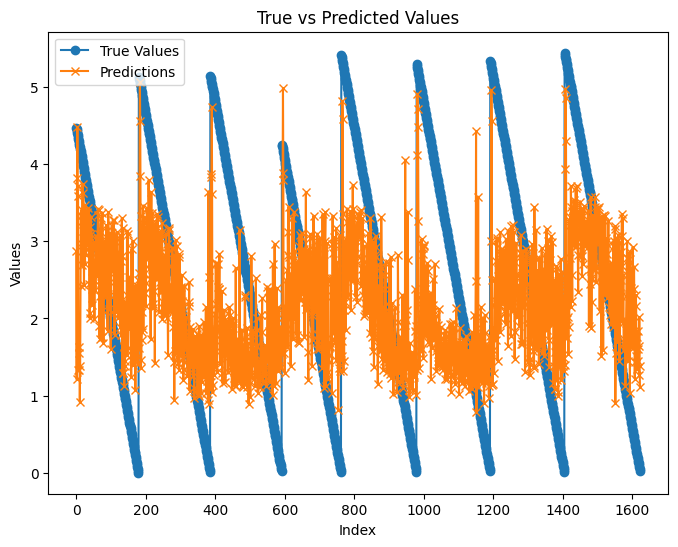

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(target_test, label="True Values", marker='o')
plt.plot(prediction, label="Predictions", marker='x')
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

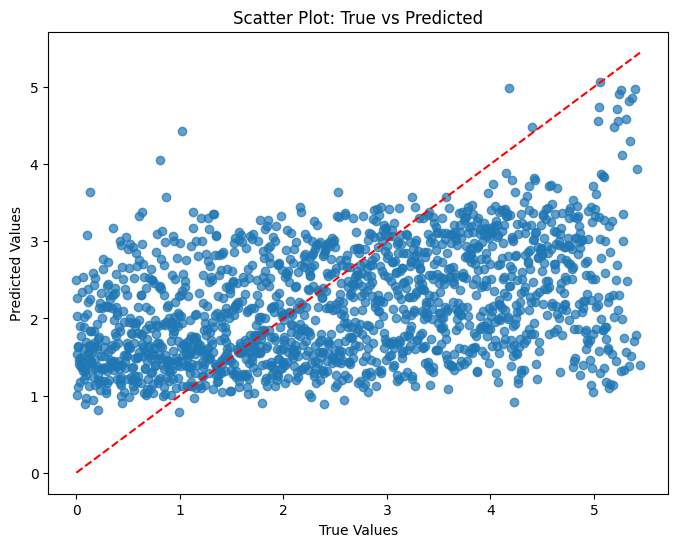

In [175]:
plt.figure(figsize=(8, 6))
plt.scatter(target_test, prediction, alpha=0.7)
plt.plot([min(target_test), max(target_test)], [min(target_test), max(target_test)], 'r--')  # Linea 45°
plt.title("Scatter Plot: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

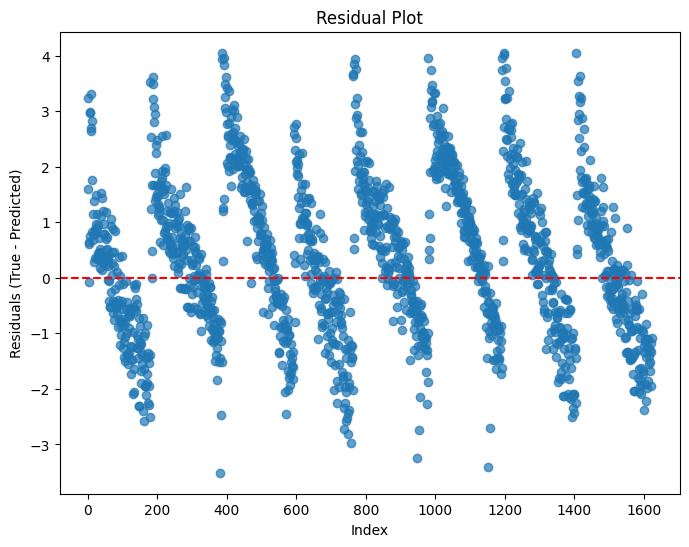

In [176]:
residuals = target_test - prediction

plt.figure(figsize=(8, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Index")
plt.ylabel("Residuals (True - Predicted)")
plt.show()

# modello con gridsearchCV

In [154]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Definiamo una griglia di parametri da testare
param_grid = {
    'num_leaves': [4, 8, 16],
    'min_data_in_leaf': [5, 10, 20],
    'learning_rate': [0.01, 0.02, 0.05],
    'feature_fraction': [0.7, 0.9],
    'bagging_fraction': [0.5, 0.7],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Definiamo il modello base senza parametri (li troveremo con grid search)
base_model = LGBMRegressor(
    boosting_type='gbdt',
    objective='fair',  # Rimane l'obiettivo "fair" come prima
    max_depth=-1,
    boosting='gbdt',
    bagging_freq=1,
    bagging_seed=0,
    metric='mae',
    verbosity=-1,
    max_bin=500,
    seed=0,
    n_jobs=-1
)

# KFold come prima, 3 fold, con lo stesso random_state per coerenza
n_fold = 3
kf_gs = KFold(n_splits=n_fold, shuffle=True, random_state=1337)

# GridSearchCV con le impostazioni desiderate
clf_gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usare MAE (negativa) come metrica di ottimizzazione
    cv=kf_gs,
    verbose=1,
    n_jobs=-1
)

# Eseguiamo la grid search sul train set
clf_gs.fit(train_X, target)

print("Migliori Parametri trovati da GridSearch:")
print(clf_gs.best_params_)

# Ora alleniamo un modello finale con i parametri ottimali su tutto il training set
best_params = clf_gs.best_params_
final_model_gs = LGBMRegressor(
    boosting_type='gbdt',
    objective='fair',
    metric='mae',
    max_depth=-1,
    boosting='gbdt',
    bagging_freq=1,
    bagging_seed=0,
    max_bin=500,
    seed=0,
    n_jobs=-1,
    **best_params  # Applichiamo i parametri ottimi trovati
)

final_model_gs.fit(train_X, target)

# Previsioni sul test set con il nuovo modello
prediction_gs = final_model_gs.predict(test_X)

# MAE
mae_gs = mean_absolute_error(target_test, prediction_gs)
print(f"Mean Absolute Error (MAE) con GridSearch: {mae_gs:.4f}")

# RMSE
rmse_gs = mean_squared_error(target_test, prediction_gs, squared=False)
print(f"Root Mean Squared Error (RMSE) con GridSearch: {rmse_gs:.4f}")

# R² Score
r2_gs = r2_score(target_test, prediction_gs)
print(f"R² Score con GridSearch: {r2_gs:.4f}")

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


Python(50185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50188) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50191) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(50192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 

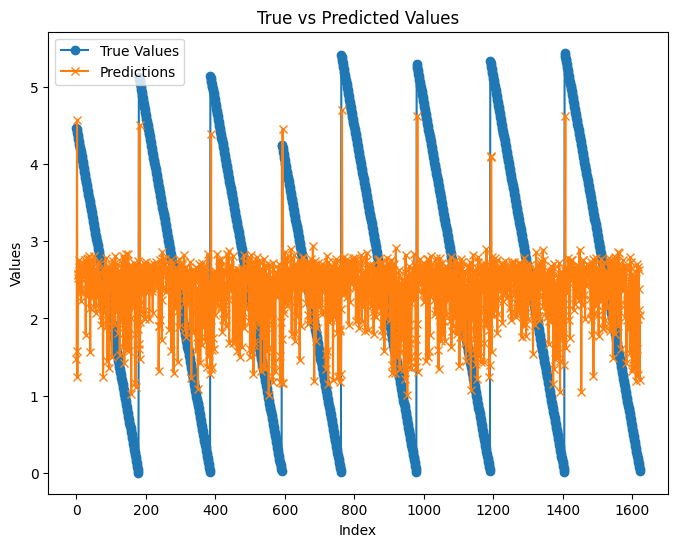

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(target_test, label="True Values", marker='o')
plt.plot(prediction_gs, label="Predictions", marker='x')
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

# Downsampling

In [178]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from fractions import Fraction


# Supponiamo di avere ancora disponibili le seguenti variabili dal codice precedente:
# best_params   (i migliori parametri trovati dal GridSearch)
# train_sample, test_sample
# features
# target_test, test_X (derivanti dal test_sample)
#
# Non sovrascriviamo quindi nulla del codice precedente, 
# ma creiamo nuove variabili per questo esperimento.

# Liste o dizionari per salvare i risultati
fractions = [1.0, 0.75, 0.5, 0.25]
mae_down_list = []
rmse_down_list = []
r2_down_list = []

# Usiamo gli stessi feature come prima
# train_sample e test_sample sono come definiti prima
# Estraiamo test_X e target_test dalle variabili già definite
# (Se già definite, non riscriviamo test_X e target_test)
# test_X = test_sample[features].values
# target_test = test_sample["target"].values
# queste variabili esistono già dal codice sopra

for frac in fractions:
    # Downsampling del train set
    # Prendiamo una frazione del train_sample
    f = Fraction(frac).limit_denominator()  # converte in frazione razionale
    num = f.numerator
    den = f.denominator

    # Selezioniamo gli indici che soddisfano la condizione:
    # "Prendi i primi num elementi di ogni blocco di den"
    indexes = [i for i in range(len(train_sample)) if i % den < num]
    train_sample_down = train_sample.iloc[indexes]
    
    # Definiamo train_X_down e target_down
    train_X_down = train_sample_down[features].values
    target_down = train_sample_down["target"].values
    
    # Creiamo un nuovo modello con gli stessi parametri ottimali
    # trovati precedentemente (best_params)
    # Non abbiamo bisogno di rifare la ricerca iperparametri
    final_model_gs_down = LGBMRegressor(
        boosting_type='gbdt',
        objective='fair',
        metric='mae',
        max_depth=-1,
        boosting='gbdt',
        bagging_freq=1,
        bagging_seed=0,
        max_bin=500,
        seed=0,
        n_jobs=-1,
        **best_params
    )
    
    # Alleniamo il modello sul dataset ridotto
    final_model_gs_down.fit(train_X_down, target_down)
    
    # Previsioni sul test
    prediction_down = final_model_gs_down.predict(test_X)
    
    # Calcoliamo le metriche e le salviamo
    mae_down = mean_absolute_error(target_test, prediction_down)
    rmse_down = mean_squared_error(target_test, prediction_down, squared=False)
    r2_down = r2_score(target_test, prediction_down)
    
    mae_down_list.append(mae_down)
    rmse_down_list.append(rmse_down)
    r2_down_list.append(r2_down)
    
    # Stampiamo i risultati per questa frazione
    print(f"Frazione di training: {frac*100:.0f}%")
    print(f"  MAE:  {mae_down:.4f}")
    print(f"  RMSE: {rmse_down:.4f}")
    print(f"  R²:   {r2_down:.4f}")
    print("-"*40)

# In questo modo abbiamo allenato e valutato un nuovo modello per ogni frazione, 
# senza sovrascrivere le variabili precedenti.
# Le metriche sono salvate in mae_down_list, rmse_down_list, r2_down_list e 
# possono essere utilizzate per un confronto successivo.

Frazione di training: 100%
  MAE:  1.1285
  RMSE: 1.3931
  R²:   0.1292
----------------------------------------
Frazione di training: 75%
  MAE:  1.1266
  RMSE: 1.3915
  R²:   0.1313
----------------------------------------
Frazione di training: 50%
  MAE:  1.1313
  RMSE: 1.3948
  R²:   0.1272
----------------------------------------
Frazione di training: 25%
  MAE:  1.1502
  RMSE: 1.4108
  R²:   0.1071
----------------------------------------


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/ve

# Quanti dati ci servono invece? 

proviamo a ridurre il numero di dati utilizzati e vediamo le performance

In [179]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from fractions import Fraction


# Supponiamo di avere ancora disponibili le seguenti variabili dal codice precedente:
# best_params   (i migliori parametri trovati dal GridSearch)
# train_sample, test_sample
# features
# target_test, test_X (derivanti dal test_sample)
#
# Non sovrascriviamo quindi nulla del codice precedente, 
# ma creiamo nuove variabili per questo esperimento.

# Liste o dizionari per salvare i risultati
fractions = [1.0, 0.8, 0.6, 0.5, 0.25]
mae_down_list = []
rmse_down_list = []
r2_down_list = []

# Usiamo gli stessi feature come prima
# train_sample e test_sample sono come definiti prima
# Estraiamo test_X e target_test dalle variabili già definite
# (Se già definite, non riscriviamo test_X e target_test)
# test_X = test_sample[features].values
# target_test = test_sample["target"].values
# queste variabili esistono già dal codice sopra

for frac in fractions:
    # Downsampling del train set
    # Prendiamo una frazione del train_sample
    n_rows = int(len(train_sample) * frac)
    train_sample_down = train_sample.iloc[:n_rows]
    
    # Definiamo train_X_down e target_down
    train_X_down = train_sample_down[features].values
    target_down = train_sample_down["target"].values
    
    # Creiamo un nuovo modello con gli stessi parametri ottimali
    # trovati precedentemente (best_params)
    # Non abbiamo bisogno di rifare la ricerca iperparametri
    final_model_gs_down = LGBMRegressor(
        boosting_type='gbdt',
        objective='fair',
        metric='mae',
        max_depth=-1,
        boosting='gbdt',
        bagging_freq=1,
        bagging_seed=0,
        max_bin=500,
        seed=0,
        n_jobs=-1,
        **best_params
    )
    
    # Alleniamo il modello sul dataset ridotto
    final_model_gs_down.fit(train_X_down, target_down)
    
    # Previsioni sul test
    prediction_down = final_model_gs_down.predict(test_X)
    
    # Calcoliamo le metriche e le salviamo
    mae_down = mean_absolute_error(target_test, prediction_down)
    rmse_down = mean_squared_error(target_test, prediction_down, squared=False)
    r2_down = r2_score(target_test, prediction_down)
    
    mae_down_list.append(mae_down)
    rmse_down_list.append(rmse_down)
    r2_down_list.append(r2_down)
    
    # Stampiamo i risultati per questa frazione
    print(f"Frazione di training: {frac*100:.0f}%")
    print(f"  MAE:  {mae_down:.4f}")
    print(f"  RMSE: {rmse_down:.4f}")
    print(f"  R²:   {r2_down:.4f}")
    print("-"*40)

# In questo modo abbiamo allenato e valutato un nuovo modello per ogni frazione, 
# senza sovrascrivere le variabili precedenti.
# Le metriche sono salvate in mae_down_list, rmse_down_list, r2_down_list e 
# possono essere utilizzate per un confronto successivo.

Frazione di training: 100%
  MAE:  1.1285
  RMSE: 1.3931
  R²:   0.1292
----------------------------------------
Frazione di training: 80%
  MAE:  1.1303
  RMSE: 1.4025
  R²:   0.1175
----------------------------------------
Frazione di training: 60%
  MAE:  1.1456
  RMSE: 1.4139
  R²:   0.1031
----------------------------------------
Frazione di training: 50%
  MAE:  1.1569
  RMSE: 1.4230
  R²:   0.0914
----------------------------------------
Frazione di training: 25%
  MAE:  1.1852
  RMSE: 1.4540
  R²:   0.0515
----------------------------------------


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/ve